# 03c - Record File Tree Representation

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip -q
!{sys.executable} -m pip install pandas -q
!{sys.executable}  -m pip install numpy -q
!{sys.executable}  -m pip install matplotlib -q
!{sys.executable}   -m pip install scipy -q
!{sys.executable}   -m pip install pyvis -q



In [2]:
import numpy as np
import pandas as pd
import json
import os
import pickle
from collections import OrderedDict
import psutil
import gc
from bisect import bisect
from scipy import spatial
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mplt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from pyvis.network import Network
import networkx as nx
import pandas as pd
import matplotlib.cm as cm
import resource
import random

In [3]:
def print_txt(msg: str):
    print(msg, end = '\r')
    text_file = open("Outputs/villreslvl_Tree_Rep.txt", "w")
    text_file.write(msg)
    text_file.close()

In [4]:
try:
    print(len(nodes),len(rel_nodes),len(matches))
except:
    print("not defined")

not defined


In [5]:
scen_name = "RSOC"
elo_class = 'medium'
####### parameter settings #######
recreate_nodes = False
subset = False
plot_clusterdist = False
node_threshold = 50
edge_threshold = 10
edge_prob_threshold = 0.01
prob_threshold = 0.05
max_numclust = 20
tw = 120 #timewindow
threshold_plot = True
plot_nodenet = False



time_list = [t for t in range(0,5001,tw)]
time_list_long = [t for t in range(0,15000,tw)]

if subset:
    scen_name +='_SS'

In [6]:
res_step = 500
resource_binsize = 50

global resource_bins
resource_bins = [ub for ub in range(0,1200000,resource_binsize)]
global resource_steps
resource_steps = [ub for ub in range(0,1200000,res_step)]

In [7]:
##directorys
input_path = 'data/scraped_matches/inputs/'
gaia_path = 'data/scraped_matches/gaia_data/'
viz_path = 'Visualizations/Tree_Rep/'

#players
player_ids = ['p1','p2']

In [8]:
#load masterdata
with open('masterdata/masterdata_dict.pkl', 'rb') as f:
        masterdata_dict = pickle.load(f)

with open('masterdata/unit_type_dict.pkl', 'rb') as f:
        unit_type_dict = pickle.load(f)        

with open('masterdata/unit_masterdata_dict.pkl', 'rb') as f:
        unit_masterdata_dict = pickle.load(f)        

with open(f'masterdata/full_resource_masterdata_dict.pkl', 'rb') as f:
        resource_masterdata = pickle.load(f)        
        
#load masterdata
with open('masterdata/elo_frames.pkl', 'rb') as f:
        elo_frames = pickle.load(f)

        resources = ['Food','Wood','Gold','Stone']

In [9]:
def get_eloFrame(elo,elo_frames):
    for elo_key in elo_frames:
        if elo >= elo_frames[elo_key]['lb'] and elo < elo_frames[elo_key]['ub']:
            return elo_key
        
def get_resbin(value):
    for ub in resource_bins:
        if value <= ub:
            return ub
        
def get_resstep(value):
    for ub in resource_steps:
        if value <= ub:
            return ub
        

In [10]:
elo_frames

{'low': {'lb': 0, 'ub': 1062, 'label': 'Low Elo'},
 'medium': {'lb': 1062, 'ub': 1501, 'label': 'Medium Elo'},
 'high': {'lb': 1501, 'ub': 3000, 'label': 'High Elo'}}

In [11]:
#load data
with open('data/scraped_matches/parsed_matches/arabia_matches.pkl', 'rb') as f:
    org_matches = pickle.load(f)

    
for match_id in org_matches:
    org_matches[match_id]['avg_elo'] = int((org_matches[match_id]['p1_elo']+org_matches[match_id]['p2_elo'])/2)
    org_matches[match_id]['elo'] = get_eloFrame(org_matches[match_id]['avg_elo'],elo_frames)

    
matches = org_matches 

if elo_class != 'all':
    matches = {}
    for key in org_matches:
        if org_matches[key]['elo'] == elo_class:
            matches[key]= org_matches[key]
    print(len(matches))




if subset:
    org_matches = matches.copy()
    subsample_keys = random.sample(list(org_matches), 13922)
    matches = {}
    for key in subsample_keys:
        matches[key] = org_matches[key]
    print(len(matches))


62498


In [12]:
simple = True
military_comp = True

### 3-D Tree Vills, Military, Epoch
global tree_dims 

key_types = ['Build','Queue','Research']
#rel_items = ['Villager', 'Loom', 'Build', 'Queue', 'Research']
id_prefix = 'ID'

########################complex setting########################
tree_dims = ['Age'] #["Villager","Military","Research"]
#load tree_dims from masterdata
for key_type in key_types:
    for sub_type in masterdata_dict[key_type]:
        tree_dims.append(sub_type)
########################simple setting########################
#overwriting complex
if simple:
    tree_dims = ['tf','Age',"Villager","Military","Build","Research"]

    
########################military composition setting########################
if military_comp:
    tree_dims = ['totres','Age']
    for type in unit_type_dict:
        print(type)
        tree_dims.append(type)
    
#############################################################################    
    
def get_node_id(state: dict):
    """get a node id string from a given game state dict"""
    id = id_prefix
    for dim in tree_dims:
        if state[dim] > 0 and state[dim] != 'None':
            id += f'_{dim}_{get_resbin(state[dim])}'
            
        
    if 'None' in id:
        print(state['totres'],id)
        print(state)
    return id

def get_node_state(id: str):
    """get a node game state from a given node id string"""
    
    state = {}
    
    id = id[len(id_prefix):]
    state_list = id.split("_")[1:]
    
    while len(state_list)>0:
        #read vals in dict
        dim = state_list[0]
        val = state_list[1]
        try:
            state[dim] = int(val)
            
        except:
            print(id)
            print(dim, state[dim],val)
        #update statelist
        state_list = state_list[2:]
        
    for dim in tree_dims:
        if dim not in state:
            state[dim] = 0
    
    return state



class TreeNode:
    """3D Tree Node Class with Dimensions Villiagers, Military Units and Epoch"""
    
    def __init__(self, id):
        
        self.id = id
        self.totres = 0 #initial, define lower
        
        #win/loss stat
        self.visits = 0
        self.win = 0
        self.loss = 0
        
        self.elos = {}
        for elo_key in elo_frames:
            self.elos[elo_key] = 0
        
        #get node state from function
        self.state = get_node_state(self.id)
        
        #add up all items from state
        self.age = self.state['Age']
        #self.tf = self.state['tf']
        self.level = 0
        for item in self.state:
            self.totres += self.state[item]
            
        self.totres = get_resbin(self.totres)
            
        #create vector without tf info
        self.state_vector = []
        for dim in tree_dims[1:]:
            if dim in self.state:
                self.state_vector.append(self.state[dim])
            else:
                self.state_vector.append(0)
        
        
        #incomming and outcomming edges
        self.in_edges = {}
        self.out_edges = {}
        
        self.in_nodes = []
        self.out_nodes = []
        
        #init cluster allocation
        self.cluster_id = "init"
        
        #add match infos
        self.match_infos = []
        
    def update_stats(self):
        self.visits = self.win + self.loss
        self.winrate = self.win/self.visits
        
def use_edge(out_node: TreeNode,in_node: TreeNode, bol_win: bool,elo):
    """update the edge values for the transition from one game state value to another"""
    
    #add values
    if bol_win:
        in_node.win +=1
    else:
        in_node.loss +=1
        
    #update elo
    in_node.elos[elo] +=1
    
    #add edge or edgecount for out and in node
    if in_node.id in out_node.out_edges:
        out_node.out_edges[in_node.id] += 1
    else:
        out_node.out_edges[in_node.id] = 1
        
    if out_node.id in in_node.in_edges:
        in_node.in_edges[out_node.id] += 1
    else:
         in_node.in_edges[out_node.id] = 1
    
    #add to in_node/out_nodes list
    out_node.out_nodes.append(in_node)
    in_node.in_nodes.append(out_node)
            
    #update stats
    in_node.update_stats()

def get_distance(node1: TreeNode, node2: TreeNode):
    """return cosine similarity between 2 TreeNodes"""
    dist = (spatial.distance.cosine(node1.state_vector,node2.state_vector))
    return dist
    
    
class TreeNodeCluster:
    def __init__(self,idx,totres, nodes: list):
        
        self.idx = idx
        self.id = "init"
        self.totres = totres
        
        self.nodes = nodes
        self.size = len(nodes)
    
        
        self.state_keys = []
        
        #lower and upper bounds
        self.state_lbs = {}
        self.state_ubs = {}
        self.state_avgs = {}
        self.res_ub = 0
        
        #win/loss stat
        self.visits = 0
        self.win = 0
        self.loss = 0
        self.winrate = 0
        
        #intra distance
        self.avg_intra_dist = 0
        
        #get weighted cluster vector 
        self.cluster_vector = [0 for dim in tree_dims]
        for node in self.nodes:
             for idx, val in enumerate(node.state_vector):
                self.cluster_vector[idx] += (val/len(self.nodes))
        
        
        self.label = "init"
        self.dominant_key = "init"
        self.update_stats()
        
        #edges
        self.in_edges = {}
        self.out_edges = {}
        
        #allocate nodes to cluster
        for node in self.nodes:
            node.cluster_id = self.id
        
        #pull match info one level higher
        self.match_infos = {}
        self.double_matches = 0
        for node in self.nodes:
            for match in node.match_infos:
                match_id = match['match_id']
                
                if match_id not in self.match_infos:
                    self.match_infos[match_id] = match
                else: 
                    del self.match_infos[match_id]
                    self.double_matches +=1
        
    def update_stats(self):
        
        #reset vals
        self.visits = 0
        self.win = 0
        self.loss = 0
        max_state_val = 0
        
        #loop over nodes 
        for node in self.nodes:
            self.visits += node.visits
            self.win += node.win
            self.loss += node.loss
            self.winrate = self.win/self.visits
            
            for state_key in node.state:
                try:
                    #check if state is already there
                    if state_key not in self.state_keys:
                        self.state_keys.append(state_key)
                        self.state_lbs[state_key] = node.state[state_key]
                        self.state_ubs[state_key] = node.state[state_key]
                        self.state_avgs[state_key] = node.state[state_key] * node.visits
                        
                    else:
                        if self.state_lbs[state_key] > node.state[state_key]:
                                self.state_lbs[state_key] = node.state[state_key]
                        if self.state_ubs[state_key] < node.state[state_key]:
                                self.state_ubs[state_key] = node.state[state_key]
                        
                        #add state info
                        self.state_avgs[state_key] += node.state[state_key] * node.visits            
                                
                except:
                    print("error:",self.state_lbs[state_key],node.state[state_key])
                
                #update res
                self.res_ub += self.state_ubs[state_key]
                
                
        #find dominant key
        for state_key in self.state_keys:
            if state_key != 'totres':
                self.state_avgs[state_key] = round(self.state_avgs[state_key] / self.visits,2)
                if self.state_avgs[state_key] > max_state_val:
                    max_state_val = self.state_avgs[state_key] #
                    self.dominant_key = state_key
        
        #create label
        self.label = f"ID_totres_{self.totres}"
        if self.dominant_key != "init":
            self.label += "_" + self.dominant_key
        for state_key in self.state_keys:
            if state_key != 'totres':
                if self.state_ubs[state_key] > 0:
                    if self.state_lbs[state_key] == self.state_ubs[state_key]:
                         self.label += f'_{state_key}_{self.state_lbs[state_key]}'
                    else:
                        self.label += f'_{state_key}_{self.state_lbs[state_key]}-{self.state_ubs[state_key]}-(AVG: {self.state_avgs[state_key]})'

        #loop over nodes 
        total_dist = 0
        c = 0
        for node1 in self.nodes:
            for node2 in self.nodes:
                total_dist += get_distance(node1,node2)
                if node1 != node2:
                    c += 1
        if c != 0:
            self.avg_intra_dist = total_dist/c
        
        #finalize values
        self.id = self.label
        

        
    def get_cluster_edges(self):
        for intern_node in self.nodes:
            #in edges
            for extern_node in intern_node.in_nodes:
                if extern_node.cluster_id == "init":
                    pass
                else:
                    if extern_node.cluster_id not in self.in_edges:
                        self.in_edges[extern_node.cluster_id] = 1
                    else:
                        self.in_edges[extern_node.cluster_id] += 1
            
            #out_edges
            for extern_node in intern_node.out_nodes:
                if extern_node.cluster_id == "init":
                    pass
                else:
                    if extern_node.cluster_id not in self.out_edges:
                        self.out_edges[extern_node.cluster_id] = 1
                    else:
                        self.out_edges[extern_node.cluster_id] += 1

                        
def get_clust_distance(clust1: TreeNodeCluster, clust2: TreeNodeCluster):
    """return cosine similarity between 2 TreeNodesClusters"""
    dist = (spatial.distance.cosine(clust1.cluster_vector,clust2.cluster_vector))
    return dist
        
                                        
def norm_vectors(vectorset: list):
    """ Normalize vecotors in a list of vectors"""
    for idx,vector in enumerate(vectorset):
        vectorset[idx].append(1)
        
    
    #create empty max vector
    max_vector = [0 for e in vectorset[0]]

    for vector in vectorset:
        for idx,val in enumerate(vector):
            if val > max_vector[idx]:
                max_vector[idx] = val
                
    normed_vectorset = vectorset
    
    for vec_idx,vector in enumerate(vectorset):
        for val_idx,val in enumerate(vector):
            if max_vector[val_idx] != 0:
                normed_vectorset[vec_idx][val_idx] = round(val / max_vector[val_idx],10)
    
    return normed_vectorset

Villager
Monk
Trade Cart
Infantry
Foot Archer unit
Cavalry
Siege unit
Gunpowder
Ship
Mounted Archer


In [13]:
#create root node from empty gamestate
init_state = {}
for dim in tree_dims:
    init_state[dim] = 0

  
    
if recreate_nodes:
    #create nodedict
    nodes = {}
    
    root_node_id = get_node_id(init_state)
    nodes[root_node_id] = TreeNode(root_node_id)

    #collect stats
    stat_list = []


    ############LOOP#####################


    for index,match_id in enumerate(matches):
        #determine winner and elo of each match
        winner = player_ids[matches[match_id]['winner']]
        elo = matches[match_id]['elo']
        #open inputs
        with open(matches[match_id]['input_fn'], 'rb') as f:
                    inputs = pickle.load(f) 
        
        #only get inputs from active player
        for p_id in player_ids:
            #reset timeslot, init timeframes
            #tf = 0
            resframes = OrderedDict()
            totres = 0
            res_ub = 0
            resframes[res_ub] = []

            #initialize new session for every player
            state = {}
            state['totres'] = 0
            
            for dim in tree_dims:
                state[dim] = 0
                
            if p_id == winner:
                win = True
            else:
                win = False

            
            
            #visit root node
            if win:
                nodes[root_node_id].win += 1
            else:
                nodes[root_node_id].loss += 1
                
            #gather match specific info
            match_info = {'match_id':match_id,'p_id':p_id,'win': win}
            
            nodes[root_node_id].elos[elo] +=1    
                
            nodes[root_node_id].update_stats()
            curr_node = nodes[root_node_id]

            #sort inputs into resource slices
            for input_id in inputs:
                
                
                if inputs[input_id]['player'] == p_id:
                        # check if input rel and read spend res
                    val = 0
                    
                    
                    if inputs[input_id]['type'] in key_types and inputs[input_id]['param'] != 'None':
                        #handle ages
                        if inputs[input_id]['param'] in masterdata_dict['Ages']:  
                            val = int(resource_masterdata[inputs[input_id]['param']]['total_resources'])

                        #handles military and vills
                        elif inputs[input_id]['type'] == 'Queue':
                            val = int(resource_masterdata[inputs[input_id]['param']]['total_resources'])

                               
                    if val>0:
                        #write into input for later
                        inputs[input_id]['res'] = val
                        totres += val         
                        
                        if totres < res_ub:
                             #write into intput
                            resframes[res_ub].append(input_id) 
                        else:
                            #create new resframe
                            if not val > res_step:
                                    res_ub += res_step
                            else: res_ub += int(2*res_step)
                            
                            resframes[res_ub]= []
                            resframes[res_ub].append(input_id)

            
                
            for res_ub in resframes:
                #update tf
                state['totres'] = res_ub

                for input_id in resframes[res_ub]:
                    input = inputs[input_id]

                    if input['type'] in key_types:
                    #only select from key type

                    ##STATE UPDATE after Input ######################
                        ########################complex setting########################
                        if not simple:
                            if input['param'] in masterdata_dict['Ages']:
                                #handle ages
                                state['Age'] += input['res']#masterdata_dict['Ages'].index(input['param']) + 1
                            else:
                            #all other intputs    
                                if input['param'] in state:
                                    state[input['param']] += input['res']
                                else:
                                    state[input['param']] = input['res']


                        ########################military comp setting########################        
                        elif military_comp:
                            if input['param'] != 'None':
                                #handle ages
                                if input['param'] in masterdata_dict['Ages']:  
                                    state['Age'] = input['res']#masterdata_dict['Ages'].index(input['param']) + 1
                                #handles military and vills
                                if input['type'] == 'Queue':
                                    state[unit_masterdata_dict[input['param']]['Type']] += input['res']
                                    



                ############################## NODE UPDATE after TF ############################
                ## get target node id
                next_node_id = get_node_id(state)

                #check for double click ups
                if not curr_node.id == next_node_id:

                    ##check if node exists, if not create it
                    if next_node_id not in nodes:
                        nodes[next_node_id] = TreeNode(next_node_id)
                        nodes[next_node_id].totres = res_ub
                    
                    ##use edge and visit node
                    use_edge(curr_node,nodes[next_node_id], win, elo)
                    
                    ##add game info
                    nodes[next_node_id].match_infos.append(match_info)
                    
                    ##update current node
                    curr_node = nodes[next_node_id]

        #log and delete
        if index % 1000==0:
            print_txt(f'Match {index}/{len(matches)} - Nodes: {len(nodes)} -Memory: {str(psutil.virtual_memory()[2])} %')
            stat_list.append(len(nodes))
            gc.collect()
    
    
    #delete with threshold 10
    del_list = []
    for node_id in nodes:
        if nodes[node_id].visits < 10:
            del_list.append(node_id)
    
    for node_id in del_list:
        del nodes[node_id]
    
    #persistate
    try:
        if not subset:
            max_rec = 0x100000
            resource.setrlimit(resource.RLIMIT_STACK, [0x100 * max_rec, resource.RLIM_INFINITY])
            sys.setrecursionlimit(max_rec)
            output = open(f'data/tree_rep/nodes/nodes_{scen_name}_{elo_class}_elo.pkl' , 'wb')
            pickle.dump(nodes, output)
            output.close() 
    except: 
        print("No saving due to error")
else:
    root_node_id = get_node_id(init_state)
    with open(f'data/tree_rep/nodes/nodes_{scen_name}_{elo_class}_elo.pkl', 'rb') as f:
        nodes = pickle.load(f)
    print(f'{len(nodes)} Nodes loaded from pkl')
    

2114862 Nodes loaded from pkl


In [14]:
if False:
    figure(figsize=(10, 10), dpi=50)
    x_axis = [ 1000 * i for i in range(int(len(matches)/1000))]
    ax = plt.gca()
    ax.tick_params(axis='y', which='major', labelsize=5)
    ax.set_xlim([0, len(matches)])
    plt.plot(x_axis,stat_list)
    plt.show()

In [15]:

if threshold_plot:
    x_th = []
    y_th = []
    threshold = 0
    last_len = 51

    while last_len > 50 and threshold < 200:

        rel_nodes = []
        rel_node_ids = []

        for node_id in nodes:
            #node.state_vector.pop(0)
            curr_node = nodes[node_id]
            if curr_node.visits >= threshold:# or curr_node.winrate > 0.6 and curr_node.winrate < 0.99 and curr_node.visits >= 10: 
                rel_nodes.append(curr_node)
                rel_node_ids.append(node_id)
                #print(curr_node.visits, "-", curr_node.winrate,"-",curr_node.id)

        x_th.append(threshold)
        y_th.append(len(rel_nodes))

        if threshold > 500:
            threshold += 10
        else:
            threshold += 1
        last_len = len(rel_nodes)
        print_txt(f'Threshold: {threshold} - Len: {last_len}                           ')
        
    output = open(f'data/tree_rep/stats/th_{scen_name}_{elo_class}_elo.pkl' , 'wb')
    pickle.dump([x_th,y_th], output)
    output.close() 

In [16]:
rel_nodes = []
rel_node_ids = []

for node_id in nodes:
    #node.state_vector.pop(0)
    curr_node = nodes[node_id]
    if curr_node.visits >= node_threshold:# or curr_node.winrate > 0.6 and curr_node.winrate < 0.99 and curr_node.visits >= 10: 
        rel_nodes.append(curr_node)
        rel_node_ids.append(node_id)
        #print(curr_node.visits, "-", curr_node.winrate,"-",curr_node.id)

print(len(nodes),len(rel_nodes))

2114862 2078


In [17]:
plt.rcParams["figure.figsize"] = (6,4)
print(len(nodes),len(rel_nodes))
#rel_nodes = rel_nodes[:1000]
totres_node_dict = {}
totres_rel_node_dict = {}

for totres in resource_steps:
    totres_node_dict[totres] = 0
    totres_rel_node_dict[totres] = 0
    if totres >= 15000:
        break
    
for node_id in nodes:
    node_totres = nodes[node_id].totres
    if node_totres <= 12000:
        totres_node_dict[node_totres] +=1
    
for node_id in rel_node_ids:
    totres_rel_node_dict[nodes[node_id].totres] +=1
    
totres_node_df = pd.DataFrame.from_dict(totres_node_dict,orient='index')
totres_rel_node_df = pd.DataFrame.from_dict(totres_rel_node_dict,orient='index')


output = open(f'data/tree_rep/stats/slot_node_df{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(totres_node_df, output)
output.close()

output = open(f'data/tree_rep/stats/slot_rel_node_df{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(totres_rel_node_df, output)
output.close()



2114862 2078


In [18]:
len(rel_nodes)

for node in rel_nodes:
    pass#print(node.totres)

In [19]:
if plot_nodenet:
    
    seq_net = Network(height='750px', width='100%', bgcolor='#FFFFFF', font_color='black',notebook=True,  directed=True, layout = True) #

    # set the physics layout of the network
    #seq_net.barnes_hut()

    #colorpalette
    cmap = cm.get_cmap('bwr_r')

    #shapelist:
    shapes = ['dot','triangle','square','star']

    #add nodes
    for node in rel_nodes:
        #determin color by winrate
        color = mplt.colors.to_hex(cmap(int(node.winrate*255)))

        seq_net.add_node(node.id, color = color,
                         label = str(round(node.winrate,2)) + "_" + str(node.visits), 
                         value = node.visits, title = node.id , level = node.totres*0.005, 
                         Y= node.winrate*100
                         , x = node.winrate*100) #level=

    for node in rel_nodes:
        for out_node_id in node.in_edges:

            if out_node_id in rel_node_ids:
                out_node = nodes[out_node_id]

                #if node.in_edges[out_node.id] >= out_node.visits*prob_threshold:#edge_threshold:#and abs(round(node.winrate-out_node.winrate,2)) > 0.05 :
                seq_net.add_edge(out_node.id, node.id, value=node.in_edges[out_node.id],
                                 title=f'Prob: {round(node.in_edges[out_node.id]/out_node.visits,2)} - Use: {node.in_edges[out_node.id]}-  WRD: {round(node.winrate-out_node.winrate,2)}')


    seq_net.toggle_physics(False)
    seq_net.save_graph(f'data/tree_rep/seq_net_{scen_name}_{elo_class}_elo.html')
    #seq_net.show(f'data/tree_rep/seq_net_{scen_name}_{elo_class}_elo.html')


In [20]:
numclust = max_numclust
numclust_dist_dict = {}
res_node_dict = {}

#for numclust in range(max_numclust-1,max_numclust):
if True:    
    #collect statistics for all numbers of clusters in the range
    numclust_dist_dict[numclust] = {}
    

    res_ub = 0
    snapshot_res = 3000
    cluster_dict = {}
    size_limit = 100000000000

    #initilize res list und root cluster mit root node
    res_list = [0]
    cluster_dict[res_ub] = {}
    cluster_dict[res_ub][0] = TreeNodeCluster(0,0,[nodes[root_node_id]])
    
    
    while True:
        #print_txt(f'Curr Numclust: {numclust} - res_ub: {res_ub}')
        res_ub += res_step
        res_node_dict[res_ub] = []
        
        #for each timeframe slice - cluster nodes around mainlines with weighted distance between states distance in higher number is maller than in lower number
        node_list = []
        ordered_node_list = []
        visit_list = []
        
        #use euclidan distance, avoid join in case of big wr gap, add cost function for 


        #order select nodes in from tf and order by number of visits
        for node in rel_nodes:
            if node.totres == res_ub:
                idx = bisect(visit_list, node.visits)
                ordered_node_list.insert(idx,node)
                visit_list.insert(idx,node.visits)
                res_node_dict[res_ub].append(node)
                
                
        ordered_node_list.reverse()

        #if no more rel_nodes break
        if len(ordered_node_list) <= 1:
            #print_txt(f'No more at tf {curr_tf}')
            break
        else:
            cluster_dict[res_ub] = {}
            res_list.append(res_ub)

        #enforce size_limit if set
        ordered_node_list = ordered_node_list[:size_limit]

        x = [node.id for node in ordered_node_list]
        y = [node.state_vector.copy() for node in ordered_node_list]
        y_norm = norm_vectors(y)
        
        #create denogram
        linkage_data = linkage(y_norm, method='average', metric='cosine')

        if res_ub == snapshot_res:
            link_exp = linkage_data.copy()
            x_exp = x.copy()


        cluster_dict[res_ub] = {}
        #for clusters and sort into list and create TreeNodeClusters

        ##cluster
        fcluster_list = fcluster(linkage_data,numclust,criterion='maxclust')
        ##read into clusters into list dict
        clusters = {}
        for idx in range(numclust):
            clusters[idx] = []

        for idx, i in enumerate(fcluster_list):
            clusters[i-1].append(ordered_node_list[idx])

        ##convert into TreeNodeCluster and collect distance
        total_dist = 0
        c = 0
        for c_id in clusters:
            if len(clusters[c_id]) > 0:
                cluster_dict[res_ub][c_id] = TreeNodeCluster(c_id,res_ub,clusters[c_id])
                total_dist += cluster_dict[res_ub][c_id].avg_intra_dist
                c += 1

        #get dist stats
        numclust_dist_dict[numclust][res_ub] = total_dist/c
        
        
    #loop over all clusters and add edges and add to global cluster dict do lopp more conveniet and address by id
    glob_cluster_dict = {}

    for res_ub in res_list:
        for c_id in cluster_dict[res_ub]:
            cluster_dict[res_ub][c_id].get_cluster_edges()
            glob_cluster_dict[cluster_dict[res_ub][c_id].id] = cluster_dict[res_ub][c_id]
            #print(cluster_dict[curr_tf][c_id].id,cluster_dict[curr_tf][c_id].out_edges, glob_cluster_dict[cluster_dict[curr_tf][c_id].id].out_edges)

print_txt(f'{len(glob_cluster_dict)} Clusters found')
output = open(f'data/tree_rep/numclust_dist_dict__{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(numclust_dist_dict, output)
output.close() 
output = open(f'data/tree_rep/restf_list_{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(res_list, output)
output.close() 

/home/niel/.conda/envs/aoeanalytics2/lib/python3.8/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [21]:
#tf_list

#tf_list_short = [i for i in range(480,2000,240)]#[600,960,1200,1440,1800]

#labels = []
#for tf in tf_list_short:
#    labels.append(f'TF: {tf} ({len(tf_node_dict[tf])} rem. nodes)')

In [22]:
if plot_clusterdist:

    fig, ax = plt.subplots()

    fig.figsize=(6,6)
    ax.set_xlim([2, max_numclust])
    ax.set_ylim([0, 0.00004])
    plt.xlabel("Number of Clusters",fontsize=14)
    plt.ylabel("Mean Intra Cluster Distance",fontsize=14)
    plt.grid(color='lightgrey', linestyle='-', linewidth=2)

    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.yaxis.offsetText.set_fontsize(14)

    #plt.title(f'Avg Intra Cluster Distance per Number of Clusters')

    for tf in tf_list_short:#tf_list[1:]:
        x = [i for i in range(2,max_numclust)]
        y = [numclust_dist_dict[numclust][tf] for numclust in x]
        if len(x)>0:
            ax.plot(x,y)
    #ax = plt.gca()


    ax.legend(labels,fontsize=14)
    plt.tight_layout()
    plt.savefig(viz_path +f'Clusterdist_numclust_time.png')
    plt.show()




In [23]:
#get info about snapshot
if False:
    curr_tf = snapshot_tf
    for c_id in cluster_dict[curr_tf]:
        print(cluster_dict[curr_tf][c_id].visits,round(cluster_dict[curr_tf][c_id].winrate,2),cluster_dict[curr_tf][c_id].id,cluster_dict[curr_tf][c_id].avg_intra_dist)

In [24]:
#Plot Dendogram

if False:
    figure(figsize=(16, 10), dpi=50)
    plt.rcParams.update({'font.size': 22})
    dendrogram(link_exp,labels =x_exp, orientation='right')
    ax = plt.gca()
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.set_xscale('linear')
    ax.set_xlim([0, 0.1])
    ax.set_xlabel('Cluster Distance(Cosine Similarity)',fontsize=16)
    #ax.set_ylabel('Nodes',fontsize=16)
    plt.tight_layout()
    plt.savefig(viz_path+ f"Dendogram_tf{snapshot_tf}.png")
    plt.show()


In [25]:

seq_net_clust = Network(height='1440px', width='100%', bgcolor='#FFFFFF', font_color='black',
                        notebook=True,  directed=True, layout = True) #

# set the physics layout of the network
#seq_net.barnes_hut()
early_tf = 480
weight_threshold = 15000
#colorpalette
cmap = cm.get_cmap('bwr_r')

#shapelist:
shapes = ['dot','triangle','square','star','diamond','triangleDown','icon']
#shapedict:
shape_dict = {'init': 'dot','Age': 'dot','Villager' :'dot', 'Monk':'dot', 'Trade Cart':'dot', 
              'Infantry':'triangle', 'Foot Archer unit':'square', 'Cavalry':'star', 
              'Siege unit':'diamond', 'Gunpowder':'triangleDown', 'Ship':'icon', 'Mounted Archer':'square'}
global xpos_dict    
xpos_dict = {'init': 0,
 'Age': 1,
 'Villager': 2,
 'Monk': 3,
 'Trade Cart': 4,
 'Infantry': 5,
 'Foot Archer unit': 6,
 'Cavalry': 7,
 'Siege unit': 8,
 'Gunpowder': 9,
 'Ship': 10,
 'Mounted Archer': 11}

#add cluster_nodes
for clust_id in glob_cluster_dict:
        cluster = glob_cluster_dict[clust_id]
        #determin color by winrate
        color = mplt.colors.to_hex(cmap(int(cluster.winrate*255)))
        seq_net_clust.add_node(cluster.id, color = color,
                               label = str(round(cluster.winrate,2)) + "_" + str(cluster.visits), 
                               value = cluster.visits, title = cluster.label , 
                               level = cluster.totres *0.001, Y= xpos_dict[cluster.dominant_key], 
                               x = xpos_dict[cluster.dominant_key], shape=shape_dict[cluster.dominant_key]) #level= # shape

        
for clust_id in glob_cluster_dict:
    in_clust = glob_cluster_dict[clust_id]
    for out_clust_id in in_clust.in_edges:
        out_clust = glob_cluster_dict[out_clust_id]
        #print(out_clust_id)
        prob = round(in_clust.in_edges[out_clust.id]/out_clust.visits,2)
        use = in_clust.in_edges[out_clust.id]
        
        if use >= weight_threshold:
            weight_use = weight_threshold
        else: weight_use = use
        
        if True:#in_clust.in_edges[out_clust.id]/out_clust.visits >= prob_threshold:#in_clust.in_edges[out_clust.id] >= edge_threshold:#and abs(round(node.winrate-out_node.winrate,2)) > 0.05 :
            seq_net_clust.add_edge(out_clust.id, in_clust.id, value=weight_use,
                                   title=f'Prob: {prob} - Use: {use}-  WRD: {round(in_clust.winrate-out_clust.winrate,2)}')

#seq_net_clust.font_size=300


In [26]:
seq_net_clust.toggle_physics(False)
seq_net_clust.save_graph(f'data/tree_rep/seq_net_clust_{scen_name}_{elo_class}_elo.html')
#seq_net_clust.show(f'data/tree_rep/seq_net_clust_{scen_name}_{elo_class}_elo.html')

In [27]:
#next steps
##color encoding of dominant troops
##ellbow method for number of clusters make them vary
## add vills


In [28]:
cluster_win_matrix = {}
cluster_freq_matrix = {}
cluster_dist_matrix = {}
cluster_infos = {}
cluster_weight_dict = {}
#create wr matrix
cluster_wr_matrix = {}
cluster_inter_dist = {}
#cluster_inter_dist:
target_stage = 3000

In [29]:
#create empty matrix
for c1_id in cluster_dict[target_stage]:
    c1 = cluster_dict[target_stage][c1_id]
    c1_label = c1.id
    
    cluster_win_matrix[c1_label] = {}
    cluster_freq_matrix[c1_label] = {}
    
    for c2_id in cluster_dict[target_stage]:
        c2 = cluster_dict[target_stage][c2_id]
        c2_label = c2.id

        cluster_win_matrix[c1_label][c2_label] = 0
        cluster_freq_matrix[c1_label][c2_label] = 0
        
    
#find wins and loses
done_matches = []


for idx,c1_id in enumerate(cluster_win_matrix):
    
    #read cluster
    c1 = glob_cluster_dict[c1_id]
    
    #init weight dict value
    cluster_weight_dict[c1_id] = 0 
    
    #introduce weight
    for art_node_idx, node in enumerate(c1.nodes):
        for art_match_idx in range(node.visits):
            #fill weight_dict
            cluster_weight_dict[c1_id] +=1
            #read cluster information
            cluster_infos[f'{c1_id}_n{art_node_idx}_m{art_match_idx}'] = {'c_id': c1.label,
                                    'idx': idx,
                                    'art_node_idx': art_node_idx,
                                     'art_match_idx': art_match_idx,
                                    'avg_intra_dist':c1.avg_intra_dist,
                                   'winrate': c1.winrate,
                                   'visits' : c1.visits}
            
            
    
    
    #read double matches into freq matrix
    cluster_freq_matrix[c1_id][c1_id] = c1.double_matches
    
    for match_id in c1.match_infos:
        
        if match_id not in done_matches:
            
            win = c1.match_infos[match_id]['win']
            
            for c2_id in cluster_win_matrix:
                if c1_id != c2_id:
                    c2 = glob_cluster_dict[c2_id]


                    if match_id in c2.match_infos:
                        if win:
                            val = 1
                        else: val =0#-1
                        #print(win,c1_id==c2_id,cluster_win_matrix[c1_id][c2_id])
                        #write from both views wins and freqs
                        cluster_win_matrix[c1_id][c2_id] += val
                        #print(c1_id==c2_id,cluster_win_matrix[c1_id][c2_id])
                        #cluster_win_matrix[c2_id][c1_id] -= val
                        cluster_freq_matrix[c1_id][c2_id] += 1

                        #done_matches.append(match_id)
                        break

                        

for c1_id in cluster_win_matrix:
    #catch empty states
    
    cluster_wr_matrix[c1_id] = {}
    cluster_dist_matrix[c1_id] = {}

    for c2_id in cluster_win_matrix:
        
        
        if cluster_freq_matrix[c1_id][c2_id] != 0:
            
            cluster_wr_matrix[c1_id][c2_id] = cluster_win_matrix[c1_id][c2_id] /cluster_freq_matrix[c1_id][c2_id]
            if not c1_id == c2_id:
                pass#print(cluster_wr_matrix[c1_id][c2_id], cluster_win_matrix[c1_id][c2_id] /cluster_freq_matrix[c1_id][c2_id])
        else: 
            cluster_wr_matrix[c1_id][c2_id] = np.nan
        
        
        dist = get_clust_distance(glob_cluster_dict[c1_id],glob_cluster_dict[c2_id])
        cluster_dist_matrix[c1_id][c2_id] = dist
        cluster_inter_dist[f'{c1_id}_{c2_id}_{i}'] = {'inter_dist':dist,
                                                     'c1_id': c1_id,
                                                     'c2_id': c2_id,
                                                     'weight': int(cluster_weight_dict[c1_id] *  cluster_weight_dict[c2_id])}

In [30]:
win_df = pd.DataFrame.from_dict(cluster_wr_matrix,orient='index')
freq_df = pd.DataFrame.from_dict(cluster_freq_matrix,orient='index')
dist_df = pd.DataFrame.from_dict(cluster_dist_matrix,orient='index')

output = open(f'data/tree_rep/stats/win_df_{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(win_df, output)
output.close()

output = open(f'data/tree_rep/stats/freq_df_{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(freq_df, output)
output.close()

output = open(f'data/tree_rep/stats/dist_df_{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(dist_df, output)
output.close()

output = open(f'data/tree_rep/stats/cluster_infos_{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(cluster_infos, output)
output.close()


output = open(f'data/tree_rep/stats/cluster_inter_dist_{scen_name}_{elo_class}_elo.pkl' , 'wb')
pickle.dump(cluster_inter_dist, output)
output.close()

In [31]:
import seaborn as sns
#win_df = win_df.fillna(value=np.nan)

order = win_df.mean().sort_values(ascending=False).index
win_df = win_df.reindex(order,axis=1)
win_df = win_df.reindex(order,axis=0)

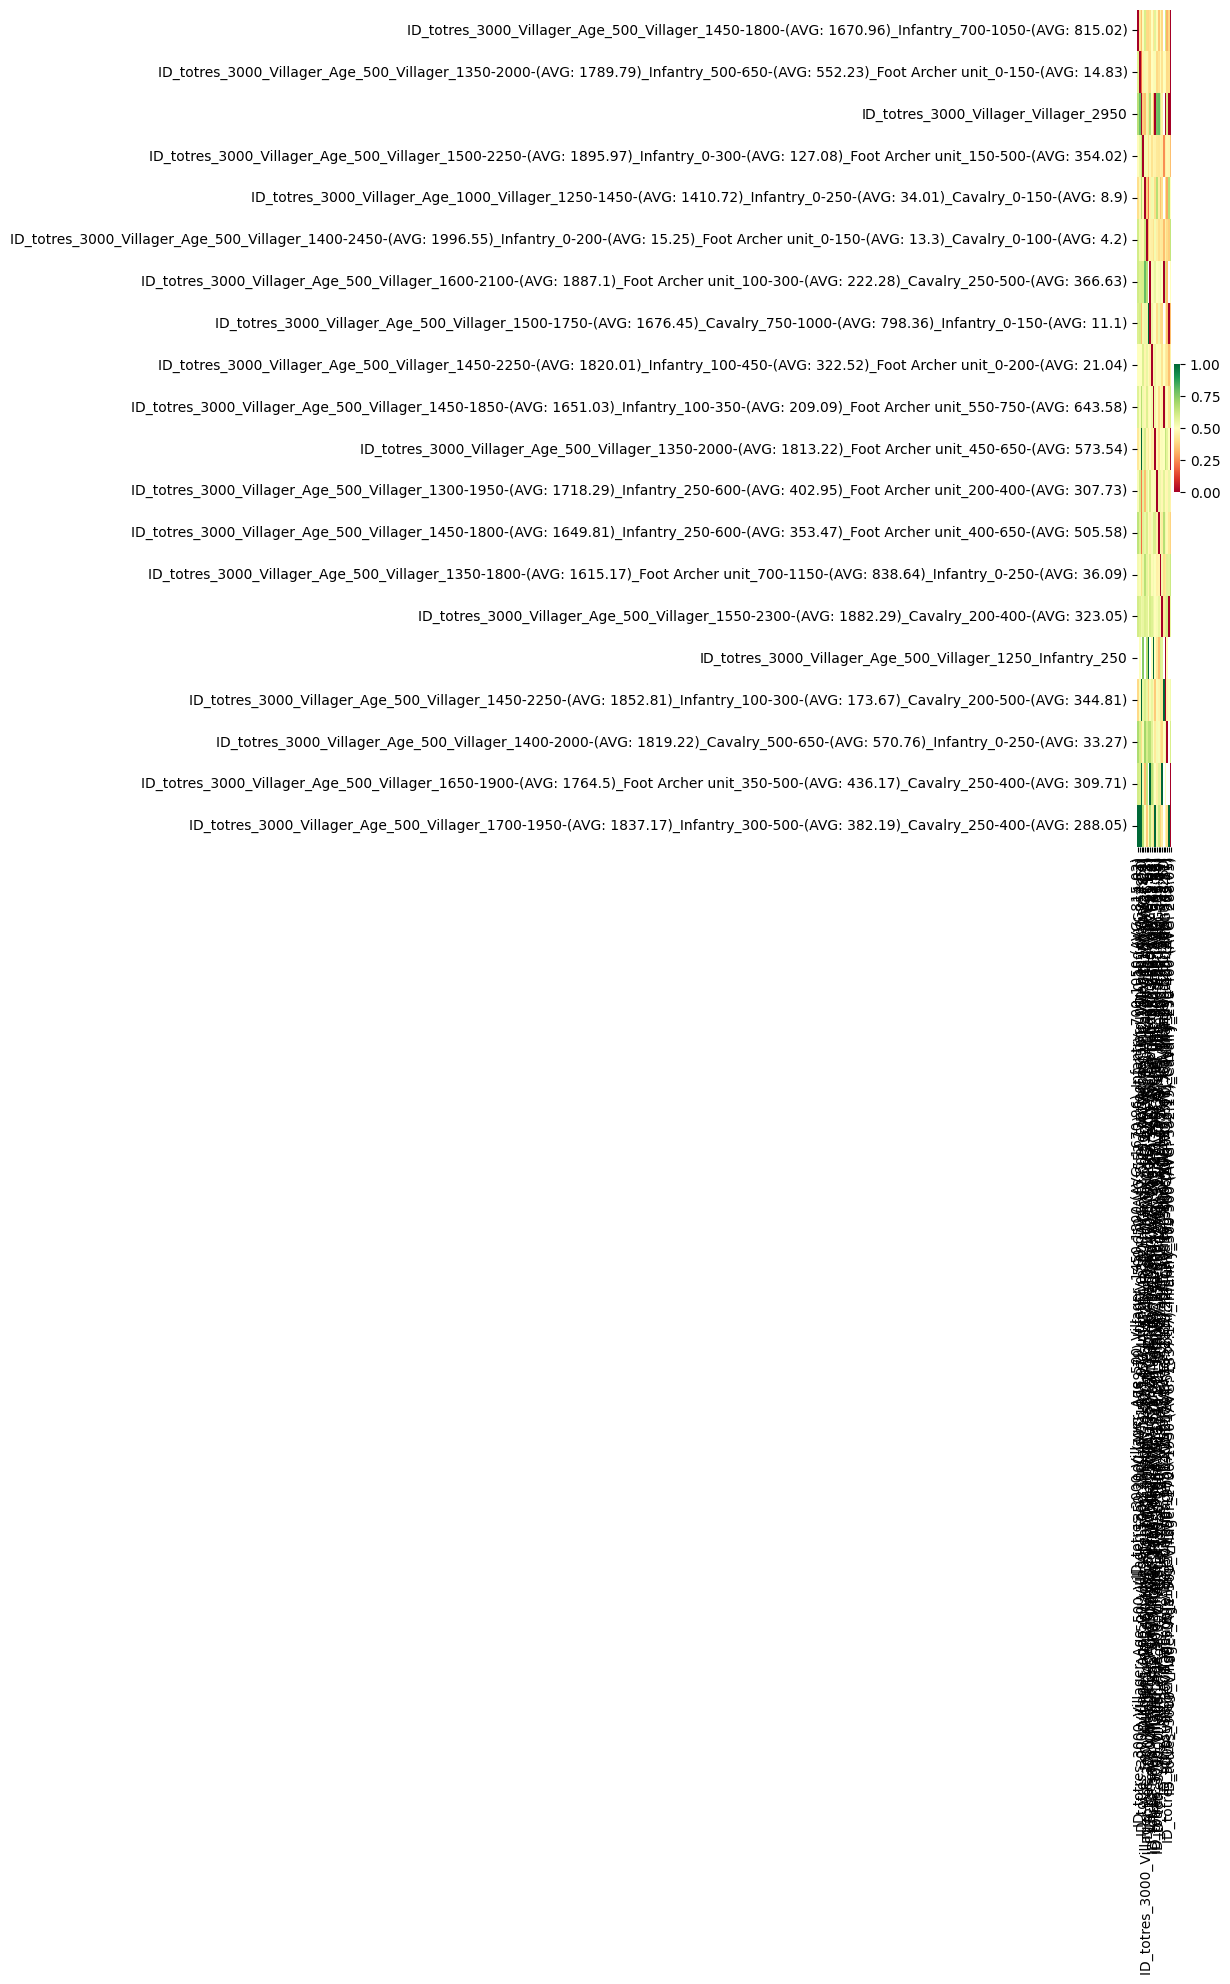

In [32]:
plt.rcParams["figure.figsize"] = (12,20)
sns.heatmap(win_df,cmap = 'RdYlGn',vmin=0,vmax=1, cbar=True)

#plt.axis([0,len(civs),0,len(civs)])

plt.tight_layout()
#plt.savefig(viz_path+name+str(elo_id)+'.pdf',format='pdf')
plt.show()